In [8]:
%load_ext autoreload
%autoreload 2
from motion_net import MotionNet
from simulation_dataset import MovingMNIST2
from simulation_dataset_datamodule import DatasetDataModule
from trainer import LightningMotionNet
import numpy as np
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from visualization import plot_spatio_temporal_data


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
root = '../data'
n_frames = 20
num_digits = 2
image_size = 64
digit_size = 28
N = 1000 # total number of samples including training and validation data
mask = np.array([1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1])
data = MovingMNIST2( root,
                     n_frames,
                     mask,
                     num_digits,
                     image_size,
                     digit_size,
                     N,
                     transform=None,
                     use_fixed_dataset=False)
data_module = DatasetDataModule(data, 4, 0.5)

motion_net = MotionNet(channels=1, state_dim=0, action_dim=0)
learning_rate = 1e-4
model = LightningMotionNet(motion_net, learning_rate)

# load from checkpoint
try:
    model.load_from_checkpoint(checkpoint_path='motion_net.ckpt', motion_net=motion_net, learning_rate=learning_rate)
except:
    print('fail to load the model')
    pass


max_epoch = 20
if torch.cuda.is_available():
    trainer = pl.Trainer(max_epochs=max_epoch, gpus=1)
else:
    trainer = pl.Trainer(max_epochs=max_epoch)
trainer.fit(model, data_module)

trainer.save_checkpoint("motion_net.ckpt")

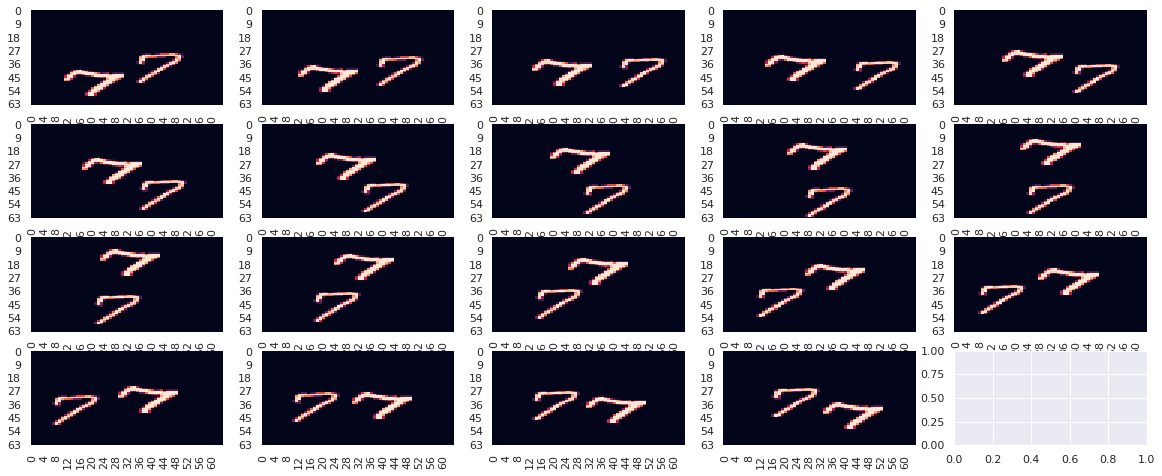

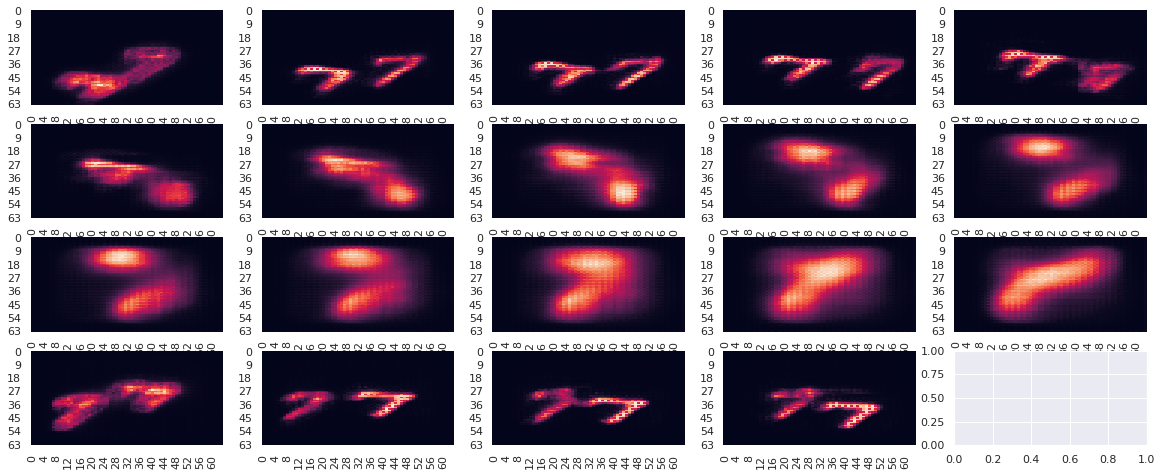

error for the new sample is 0.0242


In [18]:
root = '../data'
n_frames = 20
num_digits = 2
image_size = 64
digit_size = 28
N = 1 # total number of samples including training and validation data
mask = np.array([1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1])
data = MovingMNIST2( root,
                     n_frames,
                     mask,
                     num_digits,
                     image_size,
                     digit_size,
                     N,
                     transform=None,
                     use_fixed_dataset=False)
data_module = DataLoader(data, 1)
motion_net = MotionNet(channels=1, state_dim=0, action_dim=0)
learning_rate = 1e-4
model = LightningMotionNet(motion_net, learning_rate)

# load from checkpoint
try:
    model.load_from_checkpoint(checkpoint_path='motion_net.ckpt', motion_net=motion_net, learning_rate=learning_rate)
except:
    print('fail to load the model')
    pass

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


# predict for one sample
for idx, batch in enumerate(data_module):
    
    [_, mask, images_input, actions, state, true_data] = batch
    
    # transfer the data to gpu
    mask = mask.to(device)
    images_input = images_input.to(device)
    if actions:
        actions = actions.to(device)
    if state:
        state = state.to(device)
    
        
    output = model(images_input, actions, state, mask)  
    output = torch.stack(output, dim=1)  # Bx(T-1)xCxHxW

    if idx == 0:
        break


predicted_data = output.cpu().detach().numpy().squeeze(0).squeeze(1)  # transfer the tensor from gpu to cpu
true_data = true_data.detach().numpy().squeeze(0).squeeze(1)

# plot the true data
plot_spatio_temporal_data(true_data)
plot_spatio_temporal_data(predicted_data)


print("error for the new sample is %.4f"%np.mean((predicted_data - true_data)**2))